Анализ постов группы

In [1]:
import re
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')# стоп-слова
from nltk.corpus import stopwords
stop_words = stopwords.words('russian')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
nltk_stopwords_ru = set(stopwords.words('russian'))
from pymystem3 import Mystem
morph = Mystem()
from nltk.probability import FreqDist
from wordcloud import WordCloud
from nltk import BigramCollocationFinder
from nltk import TrigramCollocationFinder
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /home/anna/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/anna/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/anna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def read_csv_to_pandas(file_name):
    df = pd.read_csv(file_name, index_col='id', parse_dates=['date'], sep=';', encoding='utf-8')
    return df

In [3]:
posts = read_csv_to_pandas("posts.csv")
posts

,group_id,date,text,comments_count
id,,,,
217949,83421847,2022-11-28 15:40:26,Учительница истории из Техаса Лесли Раш написа...,103
244441,83421847,2025-01-08 19:13:50,«Подросток работал вместе с отцом и нечаянно о...,0
244376,83421847,2025-01-07 19:05:38,"Я очень, очень уважаю родителей, которые в раз...",64
244356,83421847,2025-01-05 22:03:16,"Когда я в миноре, спасаюсь вот этой картиной. ...",16
244351,83421847,2025-01-04 21:09:11,Я вдруг подумала: а как подвести итоги года в ...,5
...,...,...,...,...
16,83421847,2015-01-05 19:40:14,Сборник мультфильмов «НОВОГОДНИЕ КАНИКУЛЫ» (19...,0
12,83421847,2015-01-05 15:18:28,Зимнее волшебство от иллюстратора Catherine Za...,0
7,83421847,2015-01-05 13:58:37,ГИПЕРТИМНЫЙ РЕБЁНОК\n\nКаждый ребёнок уникален...,0


Предобработка, которая включает:

1. Удаление ссылок вида [id12345|Имя]
2. Замена символов новой строки на пробелы
3. Удаление всех символов, кроме букв, цифр и дефисов
4. Удаление дефисов, которые не находятся между буквами или цифрами
5. Удаление дефисов, которые не находятся между буквами или цифрами (дополнительная проверка)
6. Удаление лишних пробелов

а также:

7. Приведение текста к нижнему регистру
8. Удаление пробелов в начале и конце строки

In [4]:
def clean_text(text):
  try:
    text = re.sub(r'\[id\d+\|(.*)\],?', '', text)
    text = re.sub(r'\\n', ' ', text)
    text = re.sub(r'[^ а-яА-ЯеЕЁё0-9a-zA-Z\-]',' ',text)
    text = re.sub(r'(?![а-яА-ЯеЕЁё0-9a-zA-Z])-(\s+|$|\n)',' ',text)
    text = re.sub(r'(^|\s)+-(?<![а-яА-ЯеЕЁё0-9a-zA-Z])',' ',text)
    text = re.sub(r'\s{2,}', ' ', text)
    text = text.lower()
    text = text.strip()
    return text
  except:
    None

In [5]:
posts['cleaned_text'] = posts['text'].apply(clean_text)

Дополнение стоп-слов и удаление из списка стоп-слов слов, которые могут быть необходимы для анализа

In [6]:
adding_stop_words = ('это', 'какой', 'такой', 'этот', 'который', 'ко', 'из-под', 'изо', 'обо', 'ото', 'т', 'е', 'к', 'п', 'д', 'кг', 'что-то', 'наш', 'ваш', 'твой', 'её', 'свой')
nltk_stopwords_ru.update(adding_stop_words)
words_to_remove = ['нельзя', 'хорошо', 'больше', 'будет', 'никогда', 'сейчас']
for word in words_to_remove:
    nltk_stopwords_ru.discard(word)

In [7]:
nltk_stopwords_ru

{'а',
 'без',
 'более',
 'будто',
 'бы',
 'был',
 'была',
 'были',
 'было',
 'быть',
 'в',
 'вам',
 'вас',
 'ваш',
 'вдруг',
 'ведь',
 'во',
 'вот',
 'впрочем',
 'все',
 'всегда',
 'всего',
 'всех',
 'всю',
 'вы',
 'где',
 'д',
 'да',
 'даже',
 'два',
 'для',
 'до',
 'другой',
 'е',
 'его',
 'ее',
 'ей',
 'ему',
 'если',
 'есть',
 'еще',
 'её',
 'ж',
 'же',
 'за',
 'зачем',
 'здесь',
 'и',
 'из',
 'из-под',
 'изо',
 'или',
 'им',
 'иногда',
 'их',
 'к',
 'как',
 'какая',
 'какой',
 'кг',
 'ко',
 'когда',
 'конечно',
 'который',
 'кто',
 'куда',
 'ли',
 'лучше',
 'между',
 'меня',
 'мне',
 'много',
 'может',
 'можно',
 'мой',
 'моя',
 'мы',
 'на',
 'над',
 'надо',
 'наконец',
 'нас',
 'наш',
 'не',
 'него',
 'нее',
 'ней',
 'нет',
 'ни',
 'нибудь',
 'ним',
 'них',
 'ничего',
 'но',
 'ну',
 'о',
 'об',
 'обо',
 'один',
 'он',
 'она',
 'они',
 'опять',
 'от',
 'ото',
 'п',
 'перед',
 'по',
 'под',
 'после',
 'потом',
 'потому',
 'почти',
 'при',
 'про',
 'раз',
 'разве',
 'с',
 'сам',
 'с

Токенизация

In [8]:
def tokenize(text):
    try:
        tokenized_text = word_tokenize(text)
        text_wothout_stopwords = [word for word in tokenized_text if word not in nltk_stopwords_ru]
        return text_wothout_stopwords
    except:
        None

In [9]:
posts['tokenized_text'] = posts['cleaned_text'].apply(tokenize)

Лемматизация

In [10]:
def lemmatize(text):
    try:
        text_mystem = morph.analyze(' '.join(text))
        parts = []
        for token in text_mystem:
            pos = None
            lex = None
            if 'analysis' in token and token['analysis']:
                if 'gr' in token['analysis'][0]:
                    gr_value = token['analysis'][0]['gr']
                    pos = gr_value.split(',')[0]
                if '=' in pos:
                    pos = gr_value.split('=')[0]
                if 'lex' in token['analysis'][0]:
                    lex = token['analysis'][0]['lex']

                if lex is None:
                    lex = token['text']

                #проверка на то, что лемма не входит в список стоп-слов и запись леммы в список
                if lex not in nltk_stopwords_ru:
                    parts.append((token['text'], lex, pos))
        return parts
    except:
        None

In [11]:
posts['lemmatized_text'] = posts['tokenized_text'].apply(lemmatize)
posts

,group_id,date,text,comments_count,cleaned_text,tokenized_text,lemmatized_text
id,,,,,,,
217949,83421847,2022-11-28 15:40:26,Учительница истории из Техаса Лесли Раш написа...,103,учительница истории из техаса лесли раш написа...,"[учительница, истории, техаса, лесли, раш, нап...","[(учительница, учительница, S), (истории, исто..."
244441,83421847,2025-01-08 19:13:50,«Подросток работал вместе с отцом и нечаянно о...,0,подросток работал вместе с отцом и нечаянно оп...,"[подросток, работал, вместе, отцом, нечаянно, ...","[(подросток, подросток, S), (работал, работать..."
244376,83421847,2025-01-07 19:05:38,"Я очень, очень уважаю родителей, которые в раз...",64,я очень очень уважаю родителей которые в разбо...,"[очень, очень, уважаю, родителей, которые, раз...","[(очень, очень, ADV), (очень, очень, ADV), (ув..."
244356,83421847,2025-01-05 22:03:16,"Когда я в миноре, спасаюсь вот этой картиной. ...",16,когда я в миноре спасаюсь вот этой картиной дл...,"[миноре, спасаюсь, картиной, фотография, детст...","[(миноре, минор, S), (спасаюсь, спасаться, V),..."
244351,83421847,2025-01-04 21:09:11,Я вдруг подумала: а как подвести итоги года в ...,5,я вдруг подумала а как подвести итоги года в м...,"[подумала, подвести, итоги, года, материнстве,...","[(подумала, подумать, V), (подвести, подводить..."
...,...,...,...,...,...,...,...
16,83421847,2015-01-05 19:40:14,Сборник мультфильмов «НОВОГОДНИЕ КАНИКУЛЫ» (19...,0,сборник мультфильмов новогодние каникулы 1932-...,"[сборник, мультфильмов, новогодние, каникулы, ...","[(сборник, сборник, S), (мультфильмов, мультфи..."
12,83421847,2015-01-05 15:18:28,Зимнее волшебство от иллюстратора Catherine Za...,0,зимнее волшебство от иллюстратора catherine za...,"[зимнее, волшебство, иллюстратора, catherine, ...","[(зимнее, зимний, A), (волшебство, волшебство,..."
7,83421847,2015-01-05 13:58:37,ГИПЕРТИМНЫЙ РЕБЁНОК\n\nКаждый ребёнок уникален...,0,гипертимный ребёнок каждый ребёнок уникален и ...,"[гипертимный, ребёнок, каждый, ребёнок, уникал...","[(гипертимный, гипертимный, A), (ребёнок, ребе..."


Функция для подсчета абсолютной и относительной частоты в переданной таблице

In [12]:
def counting_word_freq(data_frame, pos = None):
    words_freq = []
    lemmas = []
    for data_frame_item in data_frame['lemmatized_text'].tolist():
        if isinstance(data_frame_item, list):
            for lemma in data_frame_item:
                if pos is not None:
                    if pos == lemma[2]:
                        lemmas.append(lemma[1])
                else:
                    lemmas.append(lemma[1])


    word_frequencies = FreqDist(lemmas)
    most_common = word_frequencies.most_common(30)
    for most_common_item in most_common:
        lemma = most_common_item[0]
        absolute_freq = most_common_item[1]
        relative_freq = most_common_item[1] / len(lemmas)
        words_freq.append({ "obj_for_freq": lemma, "absolute_freq" : absolute_freq, "relative_freq" : relative_freq })
    return words_freq

Функция для получения частотности по частям речи

In [13]:
def counting_pos_freq(data_frame):
    pos_freq = []
    pos_list = []
    for data_frame_item in data_frame['lemmatized_text'].tolist():
        if isinstance(data_frame_item, list):
            for lemma in data_frame_item:
                pos_list.append(lemma[2])

    pos_frequencies = FreqDist(pos_list)
    pos_frequencies_list = list(pos_frequencies.items())
    for pos_frequencies_item in pos_frequencies_list:
        pos = pos_frequencies_item[0]
        absolute_freq = pos_frequencies_item[1]
        relative_freq = pos_frequencies_item[1] / len(pos_list)
        pos_freq.append({ "obj_for_freq": pos, "absolute_freq" : absolute_freq, "relative_freq" : relative_freq })
    return pos_freq

Функция для отрисовки облака слов по списку объектов (частей речи\слов)

In [14]:
def draw_cloud(freq_countings_list: list[dict]):
    freq_countings_dict = dict()
    for freq_countings_list_item in freq_countings_list:
        freq_countings_dict[freq_countings_list_item["obj_for_freq"]] = freq_countings_list_item["absolute_freq"]
    wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate_from_frequencies(freq_countings_dict)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Функция для отрисовки графика по списку объектов (частей речи\слов)

In [15]:
def draw_plot(freq_countings_list: list[dict]):
    freq_countings_dict = dict()
    for freq_countings_list_item in freq_countings_list:
        freq_countings_dict[freq_countings_list_item["obj_for_freq"]] = freq_countings_list_item["absolute_freq"]
    FreqDist(freq_countings_dict).plot()
    plt.show()

Посчитаем частотность для постов и положим результат в список freqs

In [16]:
posts_words_freq = counting_word_freq(posts)

Выведем список freqs по топ 30 словам

In [17]:
posts_words_freq_table = pd.DataFrame(posts_words_freq)
posts_words_freq_table

,obj_for_freq,absolute_freq,relative_freq
0,ребенок,50799,0.024115
1,мама,14388,0.006830
2,год,10126,0.004807
3,очень,9924,0.004711
4,человек,9335,0.004431
5,говорить,9326,0.004427
6,родитель,9114,0.004326
7,мочь,9094,0.004317
8,время,9004,0.004274
9,делать,8936,0.004242


Облако слов по топ словам

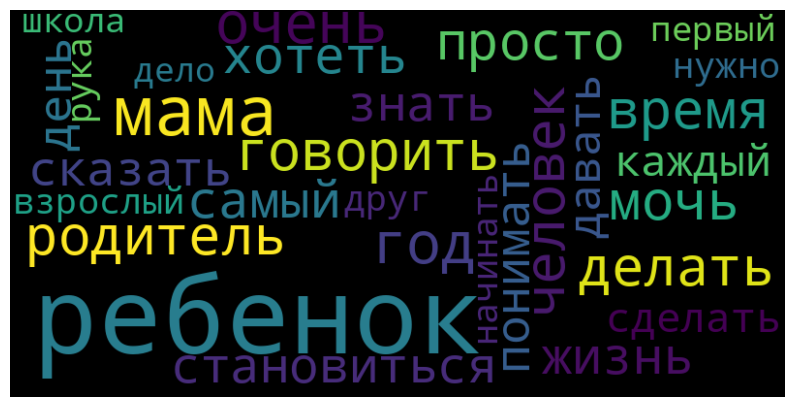

In [18]:
draw_cloud(posts_words_freq)

График частотности слов

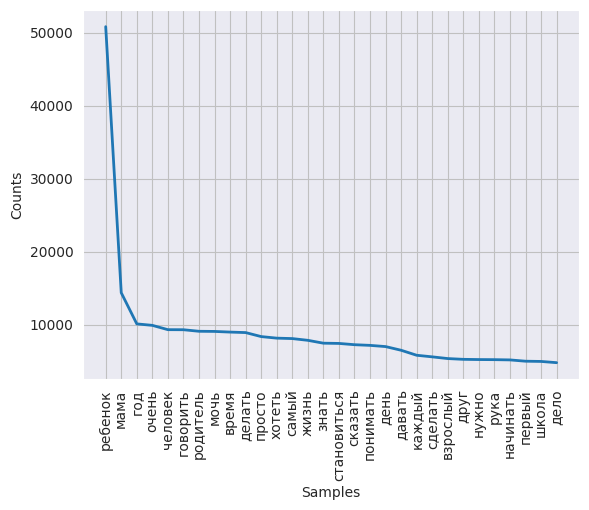

In [19]:
draw_plot(posts_words_freq)

Рассчитаем частотность по частям речи

In [20]:
posts_pos_freq = counting_pos_freq(posts)

In [21]:
posts_pos_freq_table = pd.DataFrame(posts_pos_freq)
posts_pos_freq_table

,obj_for_freq,absolute_freq,relative_freq
0,S,931007,0.441957
1,V,619984,0.294312
2,ADV,186371,0.088472
3,A,246921,0.117215
4,APRO,33351,0.015832
5,NUM,12770,0.006062
6,ANUM,9475,0.004498
7,SPRO,9822,0.004663
8,ADVPRO,16173,0.007677
9,PR,9884,0.004692


Облако по частям речи

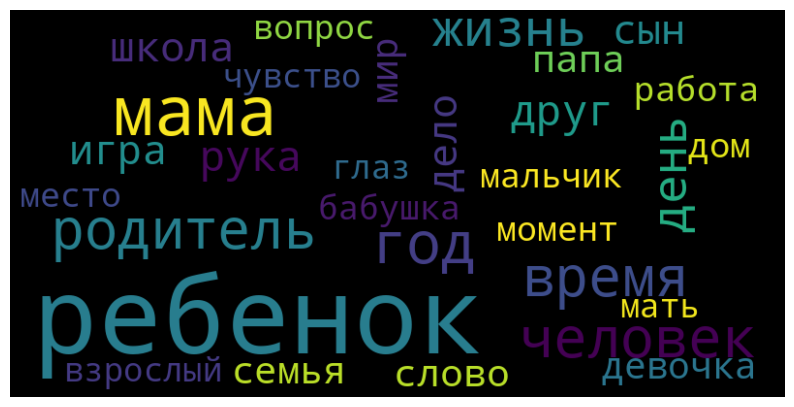

In [22]:
freq_words_for_pos = counting_word_freq(posts, 'S')
draw_cloud(freq_words_for_pos)

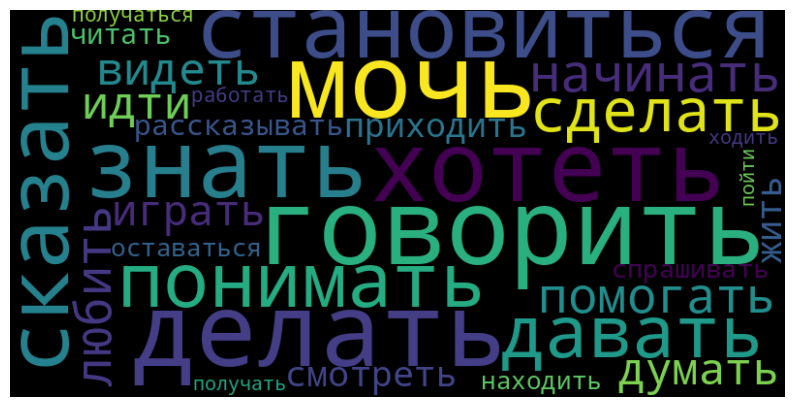

In [23]:
freq_words_for_pos = counting_word_freq(posts, 'V')
draw_cloud(freq_words_for_pos)

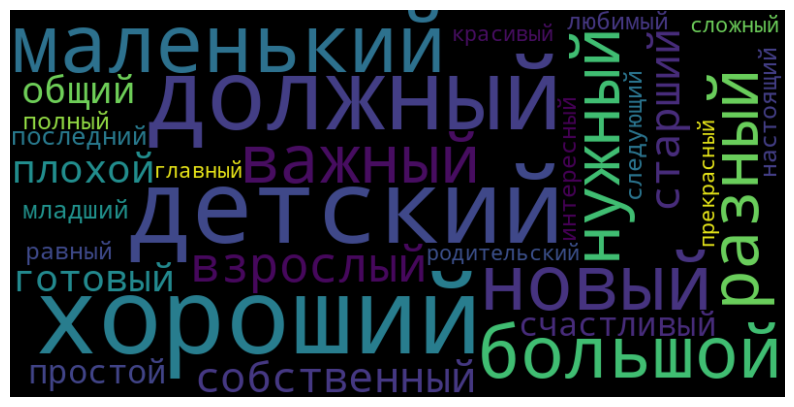

In [24]:
freq_words_for_pos = counting_word_freq(posts, 'A')
draw_cloud(freq_words_for_pos)

Токенизируем текст по предложениям для дальнейшего разделения на биграммы

In [25]:
def sentence_tokenize(text):
    try:
        tokenize_result = []
        sentences = sent_tokenize(text)
        for sentence in sentences:
            clean_sentence = clean_text(sentence)
            sentence_tokens = tokenize(clean_sentence)
            lemmatized_tokens_tuples = lemmatize(sentence_tokens)
            lemmatized_tokens = [token[1] for token in lemmatized_tokens_tuples]
            tokenize_result.append(lemmatized_tokens)
        return tokenize_result
    except:
        None

In [26]:
posts['sent_tokens'] = posts['text'].apply(sentence_tokenize)

In [27]:
all_tokens = []
for sentences_of_post in posts['sent_tokens'].tolist():
    if isinstance(sentences_of_post, list):
        for sentence in sentences_of_post:
            if isinstance(sentence, list):
                all_tokens.extend(sentence)
                all_tokens.append('.')

Создадим таблицу, в которой будут биграммы с метриками

In [28]:
bigramms = BigramCollocationFinder.from_words(all_tokens)

def exclude_punctuation(word):
    return '.' in word

bigramms.apply_word_filter(exclude_punctuation)
bigram_freq = bigramms.ngram_fd
bigram_measures = nltk.collocations.BigramAssocMeasures()
total_bigrams = bigramms.N
bigram_measures_data = []

#метрики
for bigram, freq in bigram_freq.items():
    raw_freq = freq / total_bigrams
    pmi = bigramms.score_ngram(bigram_measures.pmi, *bigram)
    chi_sq = bigramms.score_ngram(bigram_measures.chi_sq, *bigram)
    likelihood_ratio = bigramms.score_ngram(bigram_measures.likelihood_ratio, *bigram)
    student_t = bigramms.score_ngram(bigram_measures.student_t, *bigram)
    bigram_measures_data.append({
        'bigram': bigram,
        'frequency': freq,
        'pmi': pmi,
        'chi_sq': chi_sq,
        'likelihood_ratio': likelihood_ratio,
        'student_t': student_t
        })

bigram_measures_data_frame = pd.DataFrame(bigram_measures_data)
bigram_measures_data_frame

,bigram,frequency,pmi,chi_sq,likelihood_ratio,student_t
0,"(учительница, история)",6,3.764172,7.003734e+01,20.265689,2.269210
1,"(история, техас)",5,9.577953,3.814527e+03,60.521784,2.233142
2,"(техас, лесли)",5,18.216027,1.522439e+06,130.378892,2.236061
3,"(лесли, раш)",5,18.894099,2.435906e+06,140.963904,2.236063
4,"(раш, написать)",5,10.696391,8.291700e+03,74.158770,2.234720
...,...,...,...,...,...,...
749434,"(веселый, обучалок)",1,11.815148,3.602413e+03,16.380752,0.999722
749435,"(обучалок, рисовалок)",1,17.631065,2.029912e+05,24.527595,0.999995
749436,"(рисовалок, французский)",1,10.700327,1.661962e+03,12.928865,0.999399
749437,"(считать, рисовалок)",1,6.760700,1.065276e+02,7.475508,0.990778


То же самое для триграмм

In [29]:
trigramms = TrigramCollocationFinder.from_words(all_tokens)

trigramms.apply_word_filter(exclude_punctuation)
trigram_freq = trigramms.ngram_fd
trigram_measures = nltk.collocations.TrigramAssocMeasures()
total_trigrams = trigramms.N
trigram_measures_data = []

for trigram, freq in trigram_freq.items():
    raw_freq = freq / total_trigrams
    pmi = trigramms.score_ngram(trigram_measures.pmi, *trigram)
    chi_sq = trigramms.score_ngram(trigram_measures.chi_sq, *trigram)
    likelihood_ratio = trigramms.score_ngram(trigram_measures.likelihood_ratio, *trigram)
    student_t = trigramms.score_ngram(trigram_measures.student_t, *trigram)
    trigram_measures_data.append({
        'trigram': trigram,
        'frequency': freq,
        'pmi': pmi,
        'chi_sq': chi_sq,
        'likelihood_ratio': likelihood_ratio,
        'student_t': student_t
        })

trigram_measures_data_frame = pd.DataFrame(trigram_measures_data)
trigram_measures_data_frame

,trigram,frequency,pmi,chi_sq,likelihood_ratio,student_t
0,"(учительница, история, техас)",5,21.717165,1.723804e+07,145.244059,2.236067
1,"(история, техас, лесли)",5,28.472052,1.861709e+09,201.485688,2.236068
2,"(техас, лесли, раш)",5,37.110126,7.417048e+11,271.342796,2.236068
3,"(лесли, раш, написать)",5,29.590490,4.041988e+09,215.122674,2.236068
4,"(раш, написать, образ)",5,21.766486,1.783754e+07,152.268581,2.236067
...,...,...,...,...,...,...
920757,"(обучалок, рисовалок, французский)",1,31.916354,4.053031e+09,44.340523,1.000000
920758,"(рисовалок, французский, художница)",1,26.594426,1.013278e+08,58.888023,1.000000
920759,"(учиться, считать, рисовалок)",1,16.794953,1.138520e+05,72.453407,0.999991
920760,"(книга, адель, фабер)",1,22.641566,7.016146e+06,200.554142,1.000000


Функция фильтрации по ключу. Ключами для анализа группы с семейной тематикой могут быть, например, такие слова: мама, папа, ребенок, дом, семья, школа и др.

In [30]:
def filter_bigram_by_key(key):
    ngram_measures_filtered_data = []
    for bigram_measures_item in bigram_measures_data:
        if key in bigram_measures_item['bigram']:
            ngram_measures_filtered_data.append(bigram_measures_item)
            continue
    return ngram_measures_filtered_data

In [31]:
ngram_measures_filtered_frame = pd.DataFrame(filter_bigram_by_key('мама'))
ngram_measures_filtered_frame

,bigram,frequency,pmi,chi_sq,likelihood_ratio,student_t
0,"(обратно, мама)",16,2.792424,81.651645,35.058010,3.422627
1,"(приготавливать, мама)",13,2.236610,38.259137,20.059540,2.840510
2,"(мама, салат)",7,2.934679,40.679411,16.555438,2.299714
3,"(мама, успевать)",12,0.478636,1.341701,1.194834,0.978069
4,"(мама, просто)",40,-0.307358,1.839547,1.968763,-1.501698
...,...,...,...,...,...,...
4744,"(мама, немецкий)",1,0.570559,0.159403,0.138624,0.326644
4745,"(мама, суетиться)",1,1.703009,1.572258,0.984523,0.692855
4746,"(доводить, мама)",1,-0.377911,0.069426,0.075438,-0.299459
4747,"(мама, дита)",1,2.359054,3.345062,1.680148,0.805081


In [32]:
ngram_measures_filtered_frame = pd.DataFrame(filter_bigram_by_key('папа'))
ngram_measures_filtered_frame

,bigram,frequency,pmi,chi_sq,likelihood_ratio,student_t
0,"(настаивать, папа)",4,3.547192,39.173029,12.425791,1.828912
1,"(папа, заставать)",3,4.487420,61.535474,13.040321,1.654834
2,"(папа, везти)",4,2.751392,19.565409,8.481855,1.702985
3,"(мандарин, папа)",3,4.754207,75.205541,14.129131,1.667870
4,"(папа, заменять)",3,2.776927,15.027081,6.452069,1.479341
...,...,...,...,...,...,...
2022,"(особенность, папа)",1,0.860905,0.367470,0.295368,0.449393
2023,"(папа, благословлять)",1,5.999319,62.093513,6.460338,0.984368
2024,"(папа, второй)",1,-1.891452,1.984805,2.803242,-2.710084
2025,"(папа, север)",1,4.039961,14.535625,3.747846,0.939207


Отрисуем графы для словосочетаний со словами "мама" и "папа"

In [33]:
def show_graph(input_network):
    import networkx as nx
    import matplotlib.pyplot as plt
    g = nx.Graph()
    for key_list in input_network:
        g.add_edge(key_list[0], key_list[1])

    pos = nx.shell_layout(g)
    nx.draw(g, pos, with_labels=True, node_color='skyblue', node_size=2, edge_color='black', linewidths=1, font_size=10)
    plt


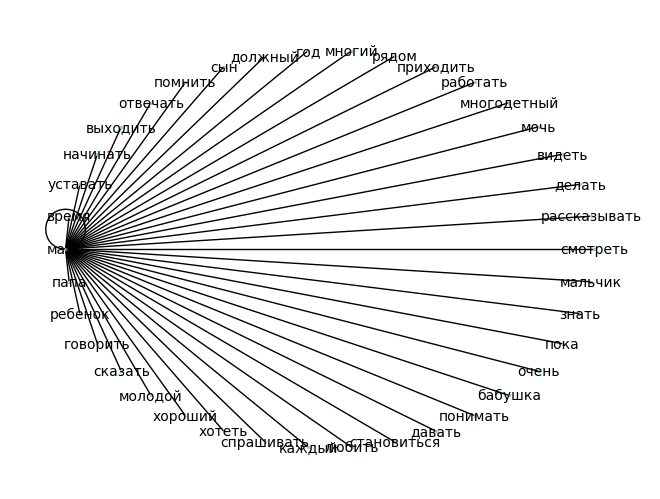

In [34]:
ngram_measures_filtered_frame = pd.DataFrame(filter_bigram_by_key('мама'))
bigram_sorted_top = ngram_measures_filtered_frame.sort_values(by='frequency', ascending=False)
bigram_sorted_top = bigram_sorted_top.head(50)['bigram']
show_graph(bigram_sorted_top)

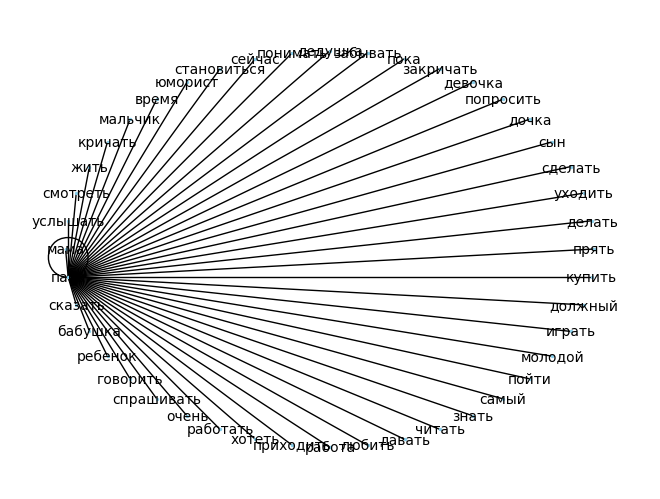

In [35]:
ngram_measures_filtered_frame = pd.DataFrame(filter_bigram_by_key('папа'))
bigram_sorted_top = ngram_measures_filtered_frame.sort_values(by='frequency', ascending=False)
bigram_sorted_top = bigram_sorted_top.head(50)['bigram']
show_graph(bigram_sorted_top)

Ключевые слова

In [36]:
def tfidf_get_key_words(sentences_tokens):
        #Подготовка данных.Преобразуем уже лемматизированные входные данные (предложения поста) в список строк, где каждое предложение представлено как строка из токенов, разделенных пробелами
        post_text = []
        if isinstance(sentences_tokens, list):
            for sentence_token in sentences_tokens:
                if isinstance(sentence_token, list):
                    if len(sentence_token) != 0:
                        post_text.append(' '.join(sentence_token))

        #Проверка на пустые данные
        if len(post_text) == 0:
            return None

        #Расчет TF-IDF. Получение матрицы
        tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1))
        post_vector = tfidf_vectorizer.fit_transform(post_text)

        #Вычисляем средние значения TF-IDF для каждого слова и список уникальных слов
        mean_tfidf = np.asarray(post_vector.mean(axis=0)).ravel()
        feature_names = tfidf_vectorizer.get_feature_names_out()

        #Сортировка индексов по убыванию значений TF-IDF и выбор топ-5 ключевых слов
        sorted_indices = np.argsort(mean_tfidf)[::-1]
        top_keywords = [feature_names[i] for i in sorted_indices[:5]]

        return top_keywords

In [37]:
posts['key_words'] = posts['sent_tokens'].apply(tfidf_get_key_words)

In [38]:
posts['key_words']

id
217949              [санта, готовый, ребенок, сын, человек]
244441    [рассыпаться, сказать, гвоздь, нужно, получаться]
244376                [уметь, ребенок, хотеть, бегать, лег]
244356    [счастие, детство, удивительно, надежда, сумерки]
244351    [сколько, совместный, красильникова, анастасия...
                                ...                        
16           [мультфильм, новогодний, серия, сборник, уолт]
12                        [иллюстратор, зимний, волшебство]
7         [ребенок, гипертимный, сын, характер, интересный]
6            [рисовалок, учиться, считать, рисовать, учить]
5               [ребенок, говорить, мочь, родитель, сейчас]
Name: key_words, Length: 6273, dtype: object

In [39]:
posts

,group_id,date,text,comments_count,cleaned_text,tokenized_text,lemmatized_text,sent_tokens,key_words
id,,,,,,,,,
217949,83421847,2022-11-28 15:40:26,Учительница истории из Техаса Лесли Раш написа...,103,учительница истории из техаса лесли раш написа...,"[учительница, истории, техаса, лесли, раш, нап...","[(учительница, учительница, S), (истории, исто...","[[учительница, история, техас, лесли, раш, нап...","[санта, готовый, ребенок, сын, человек]"
244441,83421847,2025-01-08 19:13:50,«Подросток работал вместе с отцом и нечаянно о...,0,подросток работал вместе с отцом и нечаянно оп...,"[подросток, работал, вместе, отцом, нечаянно, ...","[(подросток, подросток, S), (работал, работать...","[[подросток, работать, вместе, отец, нечаянно,...","[рассыпаться, сказать, гвоздь, нужно, получаться]"
244376,83421847,2025-01-07 19:05:38,"Я очень, очень уважаю родителей, которые в раз...",64,я очень очень уважаю родителей которые в разбо...,"[очень, очень, уважаю, родителей, которые, раз...","[(очень, очень, ADV), (очень, очень, ADV), (ув...","[[очень, очень, уважать, родитель, разборка, в...","[уметь, ребенок, хотеть, бегать, лег]"
244356,83421847,2025-01-05 22:03:16,"Когда я в миноре, спасаюсь вот этой картиной. ...",16,когда я в миноре спасаюсь вот этой картиной дл...,"[миноре, спасаюсь, картиной, фотография, детст...","[(миноре, минор, S), (спасаюсь, спасаться, V),...","[[минор, спасаться, картина], [фотография, дет...","[счастие, детство, удивительно, надежда, сумерки]"
244351,83421847,2025-01-04 21:09:11,Я вдруг подумала: а как подвести итоги года в ...,5,я вдруг подумала а как подвести итоги года в м...,"[подумала, подвести, итоги, года, материнстве,...","[(подумала, подумать, V), (подвести, подводить...","[[подумать, подводить, итог, год, материнство]...","[сколько, совместный, красильникова, анастасия..."
...,...,...,...,...,...,...,...,...,...
16,83421847,2015-01-05 19:40:14,Сборник мультфильмов «НОВОГОДНИЕ КАНИКУЛЫ» (19...,0,сборник мультфильмов новогодние каникулы 1932-...,"[сборник, мультфильмов, новогодние, каникулы, ...","[(сборник, сборник, S), (мультфильмов, мультфи...","[[сборник, мультфильм, новогодний, каникулы, к...","[мультфильм, новогодний, серия, сборник, уолт]"
12,83421847,2015-01-05 15:18:28,Зимнее волшебство от иллюстратора Catherine Za...,0,зимнее волшебство от иллюстратора catherine za...,"[зимнее, волшебство, иллюстратора, catherine, ...","[(зимнее, зимний, A), (волшебство, волшебство,...","[[зимний, волшебство, иллюстратор, иллюстратор]]","[иллюстратор, зимний, волшебство]"
7,83421847,2015-01-05 13:58:37,ГИПЕРТИМНЫЙ РЕБЁНОК\n\nКаждый ребёнок уникален...,0,гипертимный ребёнок каждый ребёнок уникален и ...,"[гипертимный, ребёнок, каждый, ребёнок, уникал...","[(гипертимный, гипертимный, A), (ребёнок, ребе...","[[гипертимный, ребенок, каждый, ребенок, уника...","[ребенок, гипертимный, сын, характер, интересный]"
